# Regime transects figure

In [1]:
import dask.distributed as dsk
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib.lines as mlines

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [3]:
# Import the data (names generalised to use for both comparisons)

temp_warm_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/warm_shelf_temp_prescribed_Pan01.nc', chunks = 'auto')
temp_warm_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/warm_shelf_temp_prescribed_ACCESS.nc', chunks = 'auto')

temp_fresh_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/fresh_shelf_temp_prescribed_Pan01.nc', chunks = 'auto')
temp_fresh_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/fresh_shelf_temp_prescribed_ACCESS.nc', chunks = 'auto')

temp_dense_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/dense_shelf_temp_prescribed_Pan01.nc', chunks = 'auto')
temp_dense_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/dense_shelf_temp_prescribed_ACCESS.nc', chunks = 'auto')

In [4]:
# Import the data (names generalised to use for both comparisons)

rho1_C_warm_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/warm_shelf_rho1_C_prescribed_Pan01.nc', chunks = 'auto')
rho1_C_warm_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/warm_shelf_rho1_C_prescribed_ACCESS.nc', chunks = 'auto')

rho1_C_fresh_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/fresh_shelf_rho1_C_prescribed_Pan01.nc', chunks = 'auto')
rho1_C_fresh_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/fresh_shelf_rho1_C_prescribed_ACCESS.nc', chunks = 'auto')

rho1_C_dense_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/dense_shelf_rho1_C_prescribed_Pan01.nc', chunks = 'auto')
rho1_C_dense_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/dense_shelf_rho1_C_prescribed_ACCESS.nc', chunks = 'auto')

In [5]:
# Import the data (names generalised to use for both comparisons)

rho1_M_warm_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/warm_shelf_rho1_M_prescribed_Pan01.nc', chunks = 'auto')
rho1_M_warm_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/warm_shelf_rho1_M_prescribed_ACCESS.nc', chunks = 'auto')

rho1_M_fresh_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/fresh_shelf_rho1_M_prescribed_Pan01.nc', chunks = 'auto')
rho1_M_fresh_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/fresh_shelf_rho1_M_prescribed_ACCESS.nc', chunks = 'auto')

rho1_M_dense_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/dense_shelf_rho1_M_prescribed_Pan01.nc', chunks = 'auto')
rho1_M_dense_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/dense_shelf_rho1_M_prescribed_ACCESS.nc', chunks = 'auto')

In [6]:
# Land and contour data
shelf_contour_1 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']
depth_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask_1 = (0 * depth_1).fillna(1)
land_1 = xr.where(np.isnan(depth_1.rename('land_1')), 1, np.nan)

depth_2 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask_2 = (0 * depth_2).fillna(1)
land_2 = xr.where(np.isnan(depth_2.rename('land_2')), 1, np.nan)
depth_2_shelf, shelf_contour_2 = shelf_mask_isobath(depth_2, 'mom5')

### Plotting

In [7]:
# Two rows of datasets
datasets = [
    [   # Row 1
        {"temp": temp_warm_1,  "rhoC": rho1_C_warm_1,  "rhoM": rho1_M_warm_1},
        {"temp": temp_fresh_1, "rhoC": rho1_C_fresh_1, "rhoM": rho1_M_fresh_1},
        {"temp": temp_dense_1, "rhoC": rho1_C_dense_1, "rhoM": rho1_M_dense_1}
    ],
    [   # Row 2
        {"temp": temp_warm_2,  "rhoC": rho1_C_warm_2,  "rhoM": rho1_M_warm_2},
        {"temp": temp_fresh_2, "rhoC": rho1_C_fresh_2, "rhoM": rho1_M_fresh_2},
        {"temp": temp_dense_2, "rhoC": rho1_C_dense_2, "rhoM": rho1_M_dense_2}
    ]
]

# Column titles
col_titles = ["Warm", "Fresh", "Dense"]

# Density levels
density_levels = [32.39, 32.45, 32.51, 32.53]


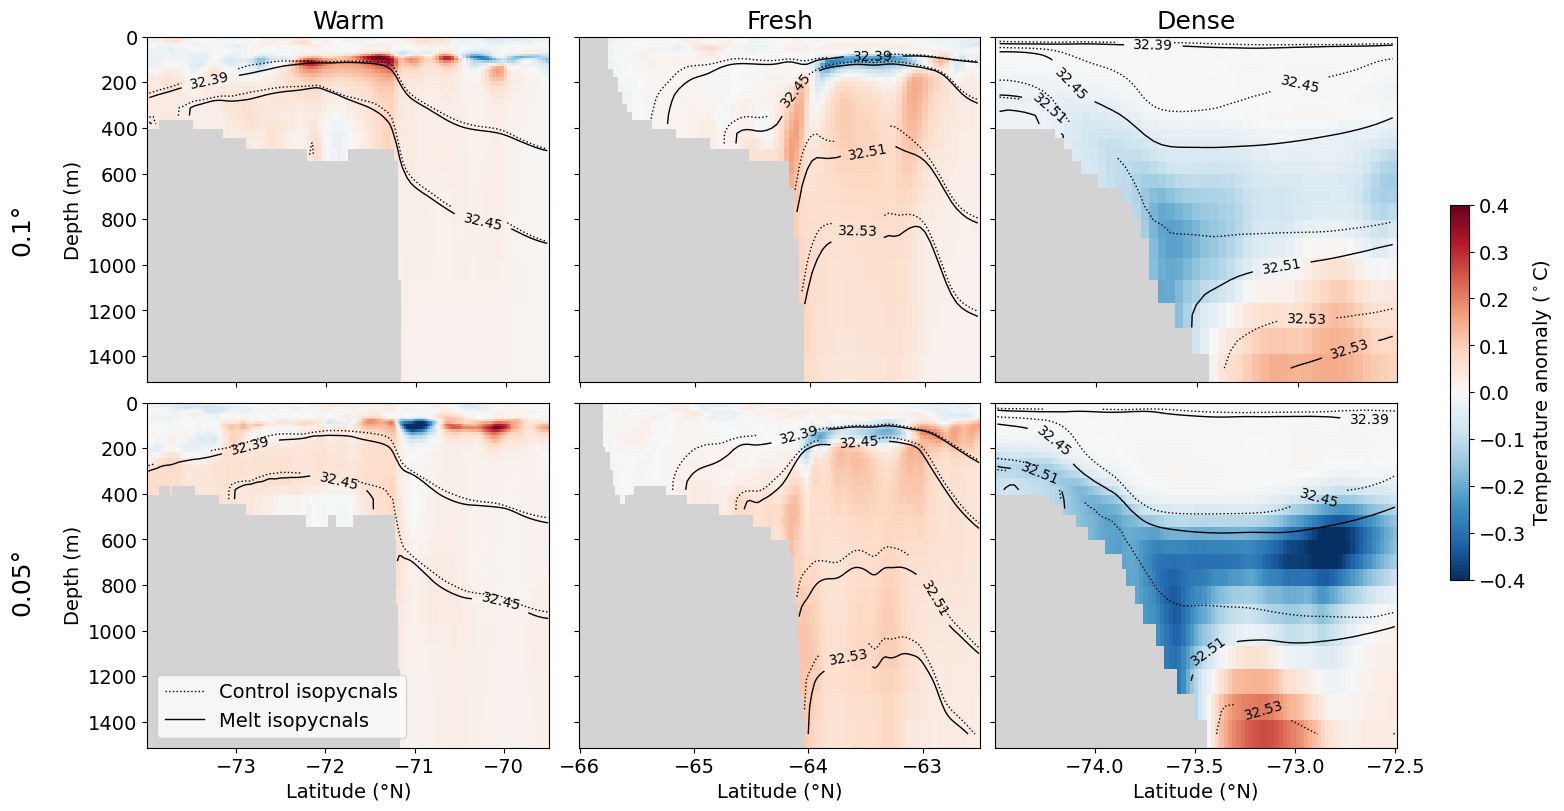

In [17]:
plt.rcParams['font.size'] = 14

# Make a 2x3 grid
fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(15, 8),
    sharey=True,
    constrained_layout=True
)

# Loop rows and columns
for i, row_axes in enumerate(axes):
    for j, ax in enumerate(row_axes):
        data = datasets[i][j]
        ax.set_facecolor('lightgrey')

        # Temperature anomaly
        h = data["temp"].plot(
            ax=ax,
            vmin=-0.4, vmax=0.4,
            cmap=plt.get_cmap('RdBu').reversed(),
            add_colorbar=False
        )

        # --- Melt isopycnals ---
        contour_melt = ax.contour(
            data["rhoM"]['yh'],
            data["rhoM"]['z_l'],
            data["rhoM"].transpose('z_l', 'yh'),
            levels=density_levels,
            colors='k',
            linewidths=1
        )

        melt_labels = ax.clabel(
            contour_melt,
            inline=True,
            fontsize=10,
            fmt='%1.2f',
            use_clabeltext=True  # places labels better and avoids collisions
        )
        
        # --- Control isopycnals ---
        contour_control = ax.contour(
            data["rhoC"]['yh'],
            data["rhoC"]['z_l'],
            data["rhoC"].transpose('z_l', 'yh'),
            levels=density_levels,
            colors='k',
            linestyles=':',
            linewidths=1
        )
        
        if j == 2:  # Only in Dense column
            # Place all control labels
            control_labels = ax.clabel(
                contour_control,
                fmt='%1.2f',
                inline=True,
                fontsize=10
            )
        
            # Midpoint longitude/latitude
            xmid = float(data["rhoC"]['yh'].mean())
        
            # Hide only those on the LEFT half
            for txt in control_labels:
                x, y = txt.get_position()
                if x <= xmid:   # left-hand side
                    txt.set_color("none")   # text invisible, gap remains
        else:
            # Hide labels in other columns
            control_labels = ax.clabel(contour_control, fmt='%1.2f', inline=True, fontsize=10)
            for txt in control_labels:
                txt.set_color("none")



        # Invert y-axis
        ax.invert_yaxis()

        # Only bottom row keeps x-tick labels
        if i == 1:
            ax.set_xlabel("Latitude (°N)")
            ax.set_title("")
        else:
            ax.set_xticklabels([])
            ax.set_xlabel("")

        # Y-label only on leftmost column
        if j == 0:
            ax.set_ylabel("Depth (m)")
        else:
            ax.set_ylabel("")

# Add column titles (only above top row)
for j, title in enumerate(col_titles):
    axes[0, j].set_title(title, fontsize=18)

# Shared colorbar (smaller)
cbar = fig.colorbar(
    h,
    ax=axes,
    orientation='vertical',
    fraction=0.015,   # thinner
    pad=0.02,
    shrink=0.8        # shorter
)
cbar.set_label("Temperature anomaly ($^\circ$C)")

# Legend
control_handle = mlines.Line2D([], [], color='k', linestyle=':', linewidth=1, label='Control isopycnals')
melt_handle = mlines.Line2D([], [], color='k', linestyle='-', linewidth=1, label='Melt isopycnals')
axes[1, 0].legend(handles=[control_handle, melt_handle], loc='lower left')

# Row labels
fig.text(-0.025, 0.72, "0.1°", va='center', ha='center', rotation=90, fontsize=18)
fig.text(-0.025, 0.28, "0.05°", va='center', ha='center', rotation=90, fontsize=18)

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_regimetransects_temp.png",
            dpi=300, bbox_inches='tight')

### Shelf regime plot

In [9]:
deptho = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho'].sel(yh=slice(None,-50))
shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']
xh = deptho['xh']
yh = deptho['yh']
land_mask = (0 * deptho).fillna(1)
land = xr.where(np.isnan(deptho.rename('land')), 1, np.nan)

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patheffects as path_effects
import cartopy.mpl.ticker as cticker

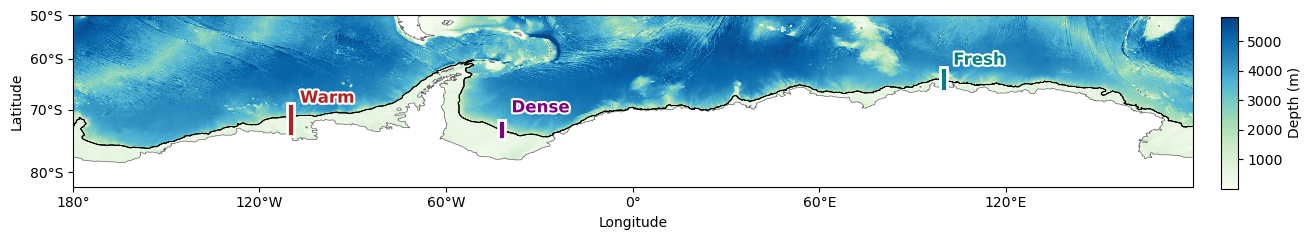

In [10]:
fig = plt.figure(figsize=(14, 7))

# Main map axis — shrink width to ~85% so colorbar fits nicely to the right
ax = fig.add_axes([0.05, 0.1, 0.8, 0.8], projection=ccrs.Miller())  # [left, bottom, width, height]

ax.set_extent([-280, -30, -82, -50], crs=ccrs.PlateCarree())

mappable = deptho.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='GnBu',
    add_colorbar=False  # Disable automatic colorbar
)

# Add ticks and labels
ax.set_xticks([-300, -240, -180, -120, -60,0], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -70, -60, -50], crs=ccrs.PlateCarree())

# Format tick labels as lon/lat
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Add axis labels manually as text
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

cbar_ax = fig.add_axes([0.87, 0.375, 0.012, 0.245])  # narrower and shorter, a bit higher on figure

# Create colorbar for the mappable
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.set_label('Depth (m)')

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels=[0, 1], colors='dimgrey', linewidths=0.5, transform=ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels=[0, 1], colors='k', linewidths=0.4, transform=ccrs.PlateCarree())

lines = [
    (-260, (-66, -62.5), "Fresh", 'teal'),
    (-110, (-74,-69.5), "Warm", 'firebrick'),
    (-42,  (-74.5, -72.5), "Dense", 'purple')
]

for lon, (lat_start, lat_end), label, color in lines:
    lon_plot = ((lon + 180) % 360) - 180
    
    # Plot white "outline" line thicker underneath
    ax.plot([lon_plot, lon_plot], [lat_start, lat_end],
            color='white', linewidth=7, transform=ccrs.PlateCarree(), zorder=2)
    # Plot colored line on top
    ax.plot([lon_plot, lon_plot], [lat_start, lat_end],
            color=color, linewidth=3, transform=ccrs.PlateCarree(), zorder=3)
    
    mid_lat = (lat_start + lat_end) / 2
    
    txt = ax.text(lon_plot + 3, mid_lat + 3, label, color=color,
                  fontsize=12, fontweight='bold', transform=ccrs.PlateCarree(), zorder=4)
    
    # Add white outline stroke to text
    txt.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='white'),
        path_effects.Normal()
    ])

# Add axis labels


plt.show()


#### Combining

In [11]:
import cmocean as cm
import matplotlib.lines as mlines
import matplotlib.patheffects as path_effects
import cartopy.crs as ccrs

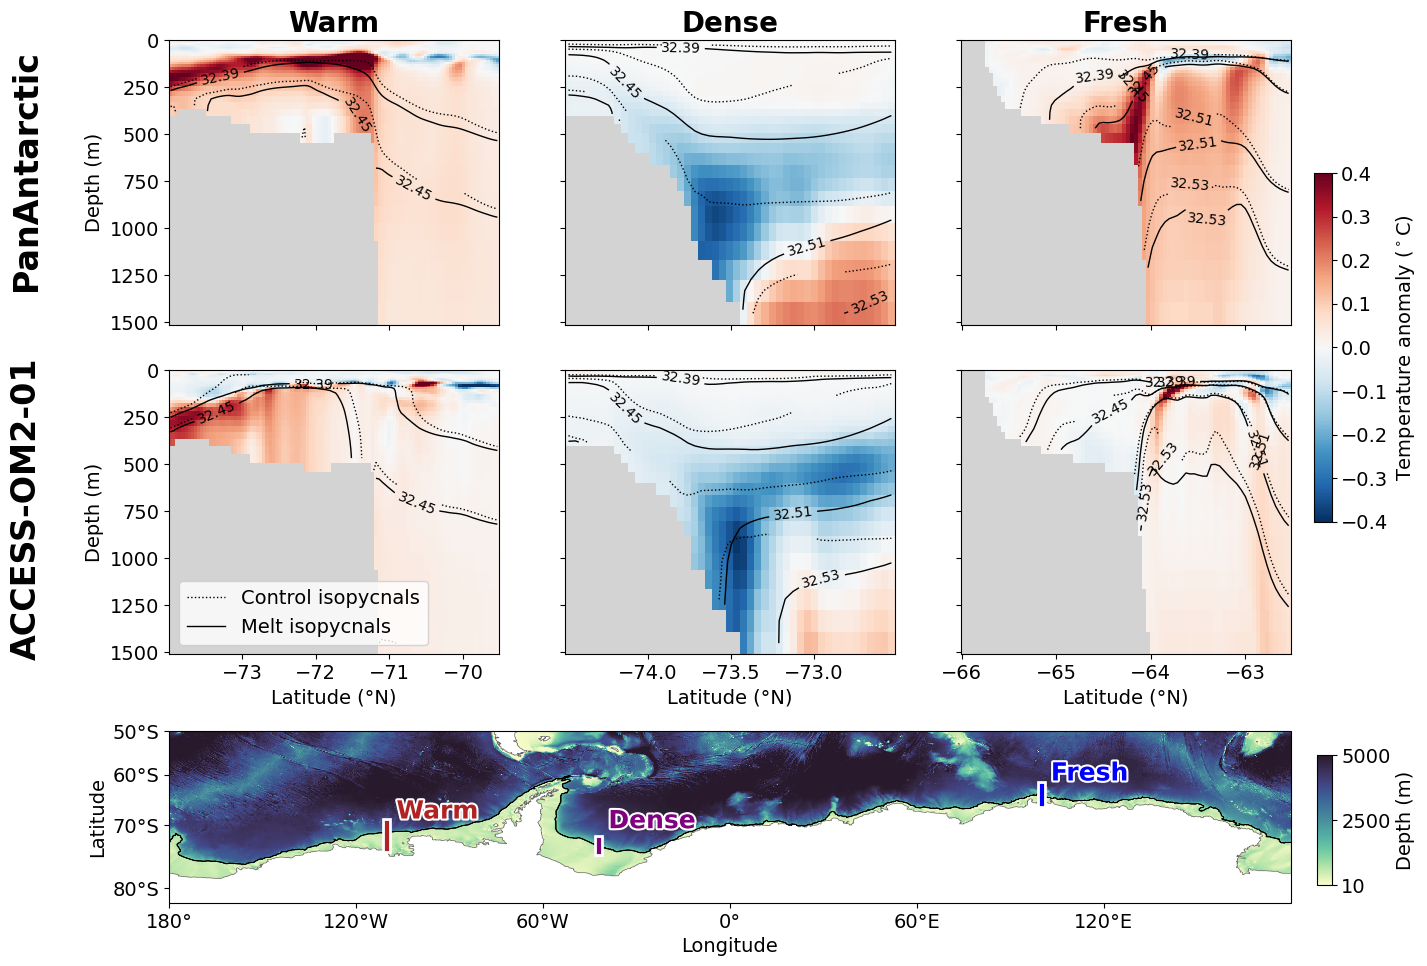

In [13]:
plt.rcParams['font.size'] = 14

# Two rows of datasets
datasets = [
    [   # Row 1
        {"temp": temp_warm_1,  "rhoC": rho1_C_warm_1,  "rhoM": rho1_M_warm_1},
        {"temp": temp_dense_1, "rhoC": rho1_C_dense_1, "rhoM": rho1_M_dense_1},
        {"temp": temp_fresh_1, "rhoC": rho1_C_fresh_1, "rhoM": rho1_M_fresh_1}
    ],
    [   # Row 2
        {"temp": temp_warm_2,  "rhoC": rho1_C_warm_2,  "rhoM": rho1_M_warm_2},
        {"temp": temp_dense_2, "rhoC": rho1_C_dense_2, "rhoM": rho1_M_dense_2},
        {"temp": temp_fresh_2, "rhoC": rho1_C_fresh_2, "rhoM": rho1_M_fresh_2}
    ]
]

# Column titles
col_titles = ["Warm", "Dense", "Fresh"]

# Density levels
density_levels = [32.39, 32.45, 32.51, 32.53]

# --- Figure with gridspec: 3 rows, 3 columns ---
fig = plt.figure(figsize=(15, 13))
gs = fig.add_gridspec(nrows=3, ncols=3, height_ratios=[1, 1, 1.2], hspace=0.15)

# First two rows: 2x3 grid (transects)
axes = np.empty((2, 3), dtype=object)
for i in range(2):
    for j in range(3):
        ax = fig.add_subplot(gs[i, j])
        axes[i, j] = ax
        data = datasets[i][j]
        ax.set_facecolor('lightgrey')

        # Pick coordinate names depending on dataset row
        if i == 0:
            xcoord = 'xh'
            ycoord = 'yh'
            zcoord = 'z_l'
        else:
            xcoord = 'xt_ocean'
            ycoord = 'yt_ocean'
            zcoord = 'st_ocean'

        # Temperature anomaly
        h = data["temp"].plot(
            ax=ax,
            vmin=-0.4, vmax=0.4,
            cmap=plt.get_cmap('RdBu').reversed(),
            add_colorbar=False
        )

        # --- Melt isopycnals ---
        contour_melt = ax.contour(
            data["rhoM"][ycoord],
            data["rhoM"][zcoord],
            data["rhoM"].transpose(zcoord, ycoord),
            levels=density_levels,
            colors='k',
            linewidths=1
        )

        melt_labels = ax.clabel(
            contour_melt,
            inline=True,
            fontsize=10,
            fmt='%1.2f',
            use_clabeltext=True  # places labels better and avoids collisions
        )
        
        # Collect melt label positions
        label_positions = [txt.get_position() for txt in melt_labels]
        
        # --- Control isopycnals ---
        contour_control = ax.contour(
            data["rhoC"][ycoord],
            data["rhoC"][zcoord],
            data["rhoC"].transpose(zcoord, ycoord),
            levels=density_levels,
            colors='k',
            linestyles=':',
            linewidths=1
        )
        
        if j == 2:  # Only in Dense column
            # Place all control labels
            control_labels = ax.clabel(
                contour_control,
                fmt='%1.2f',
                inline=True,
                fontsize=10
            )
        
            # Midpoint longitude/latitude
            xmid = float(data["rhoC"][ycoord].mean())
        
            # Hide only those on the LEFT half
            for txt in control_labels:
                x, y = txt.get_position()
                if x <= xmid:   # left-hand side
                    txt.set_color("none")   # text invisible, gap remains
        else:
            # Hide labels in other columns
            control_labels = ax.clabel(contour_control, fmt='%1.2f', inline=True, fontsize=10)
            for txt in control_labels:
                txt.set_color("none")


        ax.invert_yaxis()

        # Only bottom row keeps x-tick labels
        if i == 1:
            ax.set_xlabel("Latitude (°N)")
            ax.set_title("")
        else:
            ax.set_xticklabels([])
            ax.set_xlabel("")

        # Y-label only on leftmost column
        if j == 0:
            ax.set_ylabel("Depth (m)")
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])

# Column titles
for j, title in enumerate(col_titles):
    axes[0, j].set_title(title, fontsize=20,fontweight='bold')

# Shared colorbar for transects
cbar = fig.colorbar(
    h,
    ax=axes.ravel().tolist(),
    orientation='vertical',
    fraction=0.015,
    pad=0.02,
    shrink=0.8
)
cbar.set_label("Temperature anomaly ($^\circ$C)")

# Legend
control_handle = mlines.Line2D([], [], color='k', linestyle=':', linewidth=1, label='Control isopycnals')
melt_handle = mlines.Line2D([], [], color='k', linestyle='-', linewidth=1, label='Melt isopycnals')
axes[1, 0].legend(handles=[control_handle, melt_handle], loc='lower left')

# Row labels
fig.text(.03, 0.78, "PanAntarctic", va='center', ha='center', rotation=90, fontsize=24,fontweight='bold')
fig.text(.03, 0.52, "ACCESS-OM2-01", va='center', ha='center', rotation=90, fontsize=24,fontweight='bold')

# --- Third row: Bathymetry map spanning all columns ---
left = axes[0, 0].get_position().x0
right = axes[0, 2].get_position().x1
bottom = 0.05   # or adjust as needed
height = 0.25   # adjust height

# Get bottom of second row
bottom_of_second = axes[1, 0].get_position().y0

# Set bathymetry just below
ax_map = fig.add_axes([left, bottom_of_second - 0.25, right-left, 0.25], projection=ccrs.Miller())
ax_map.set_extent([-280, -30, -82, -50], crs=ccrs.PlateCarree())

mappable = deptho.plot(
    ax=ax_map,
    transform=ccrs.PlateCarree(),
    cmap=cm.cm.deep,
    vmin=10,
    vmax=5000,
    add_colorbar=False
)

# Ticks and labels
ax_map.set_xticks([-300, -240, -180, -120, -60, 0], crs=ccrs.PlateCarree())
ax_map.set_yticks([-80, -70, -60, -50], crs=ccrs.PlateCarree())
ax_map.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax_map.yaxis.set_major_formatter(cticker.LatitudeFormatter())
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")

# Bathymetry colorbar
cbar_ax = fig.add_axes([0.89, 0.23, 0.010, 0.1])
cbar2 = fig.colorbar(mappable, cax=cbar_ax)
cbar2.set_label('Depth (m)')
cbar2.set_ticks([10, 2500, 5000])

# Coastline + shelf mask
ax_map.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
               levels=[0, 1], colors='dimgrey', linewidths=0.5, transform=ccrs.PlateCarree())
ax_map.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
               levels=[0, 1], colors='k', linewidths=0.4, transform=ccrs.PlateCarree())

# Transect lines
lines = [
    (-260, (-66, -62.5), "Fresh", 'blue'),
    (-110, (-74, -69.5), "Warm", 'firebrick'),
    (-42,  (-74.5, -72.5), "Dense", 'purple')
]

for lon, (lat_start, lat_end), label, color in lines:
    lon_plot = ((lon + 180) % 360) - 180
    ax_map.plot([lon_plot, lon_plot], [lat_start, lat_end],
                color='white', linewidth=7, transform=ccrs.PlateCarree(), zorder=2)
    ax_map.plot([lon_plot, lon_plot], [lat_start, lat_end],
                color=color, linewidth=3, transform=ccrs.PlateCarree(), zorder=3)
    mid_lat = (lat_start + lat_end) / 2
    txt = ax_map.text(lon_plot + 3, mid_lat + 3, label, color=color,
                      fontsize=18, fontweight='bold', transform=ccrs.PlateCarree(), zorder=4)
    txt.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='white'),
        path_effects.Normal()
    ])

plt.show()

# Save figure
fig.savefig("/g/data/g40/kc5856/thesis_figures/intermodel_regimetransects_temp_with_map.png",
            dpi=300, bbox_inches='tight')


# Checking magnitudes

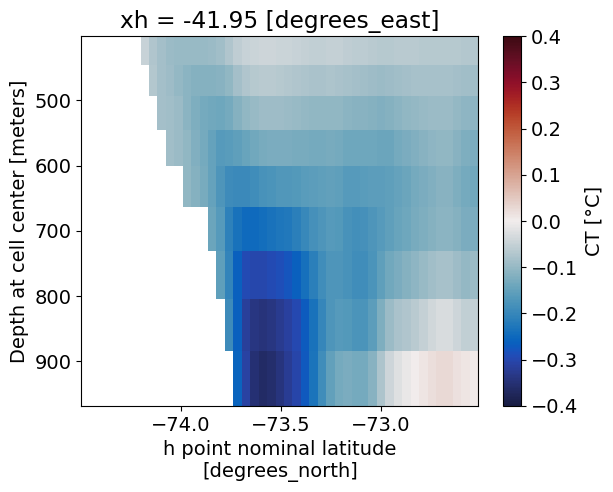

In [20]:
temp_dense_1.sel(z_l=slice(400,1000)).plot(vmin=-0.4,vmax=0.4,cmap=cm.cm.balance)
plt.gca().invert_yaxis()

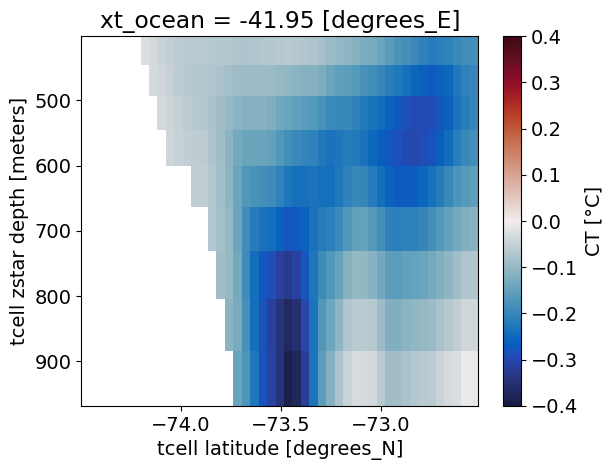

In [21]:
temp_dense_2.sel(st_ocean=slice(400,1000)).plot(vmin=-0.4,vmax=0.4,cmap=cm.cm.balance)
plt.gca().invert_yaxis()

In [22]:
# Areas for averaging
area_old_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output083/20101101.ocean_static.nc')['areacello']
area_old_acc = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']
var_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output083/20101101.ocean_month_z.nc')['so']
var_acc = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean.nc')['salt']
area_corr_01 = area_old_01*(var_01.isel(time=0,z_l=0)*0 +1)
area_corr_acc = area_old_acc*(var_acc.isel(time=0,st_ocean=0)*0 +1)

In [25]:
vol_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output083/20101101.ocean_month_z.nc')['volcello'].isel(time=0)

In [26]:
thik_01 = vol_01 / area_corr_01
thik_acc =xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean.nc')['dzt'].isel(time=0)

In [27]:
temp_dense_1_ave = temp_dense_1.sel(z_l=slice(400,1000)).weighted(thik_01.sel(xh='-42',method='nearest').fillna(0)).mean(dim='z_l')
temp_dense_2_ave = temp_dense_2.sel(st_ocean=slice(400,1000)).weighted(thik_acc.sel(xt_ocean='-42',method='nearest').fillna(0)).mean(dim='st_ocean')

In [28]:
temp_dense_1_ave.mean(dim='yh').load()

<xarray.DataArray 'CT' ()> Size: 8B
array(-0.13184507)
Coordinates:
    xh       float64 8B -41.95
    time     object 8B 2010-11-16 00:00:00

In [30]:
temp_dense_2_ave.mean(dim='yt_ocean').load()

<xarray.DataArray 'CT' ()> Size: 4B
array(-0.14428724, dtype=float32)
Coordinates:
    xt_ocean  float64 8B -41.95
    time      object 8B 1903-01-16 12:00:00